<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patches as patches
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import random
import joblib

# Data Analysis

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# loading the dataset
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 3734 files belonging to 8 classes.


In [6]:
# counting the number of class and getting the class names
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [7]:
# applying data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


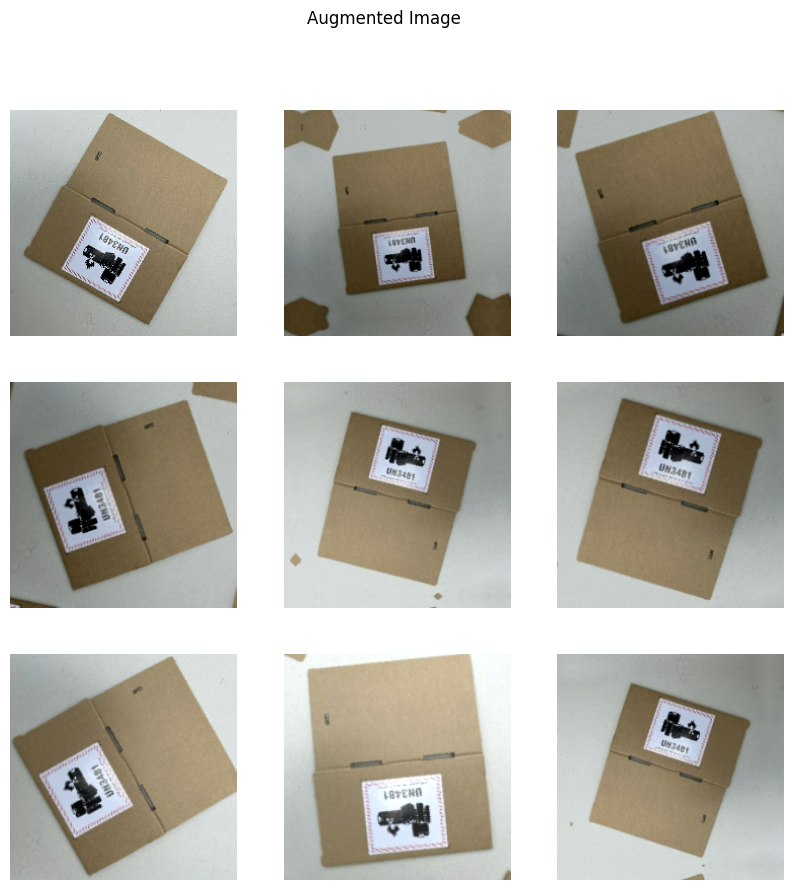

In [ ]:
# visualizing the augmented images
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [8]:
# normalizing and the images and converting the label to one hot encoding
def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [9]:
# getting the lenght of the dataset
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [10]:
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42,reshuffle_each_iteration=False)

# getting the split for traing, val and testing
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
# splitting the data
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


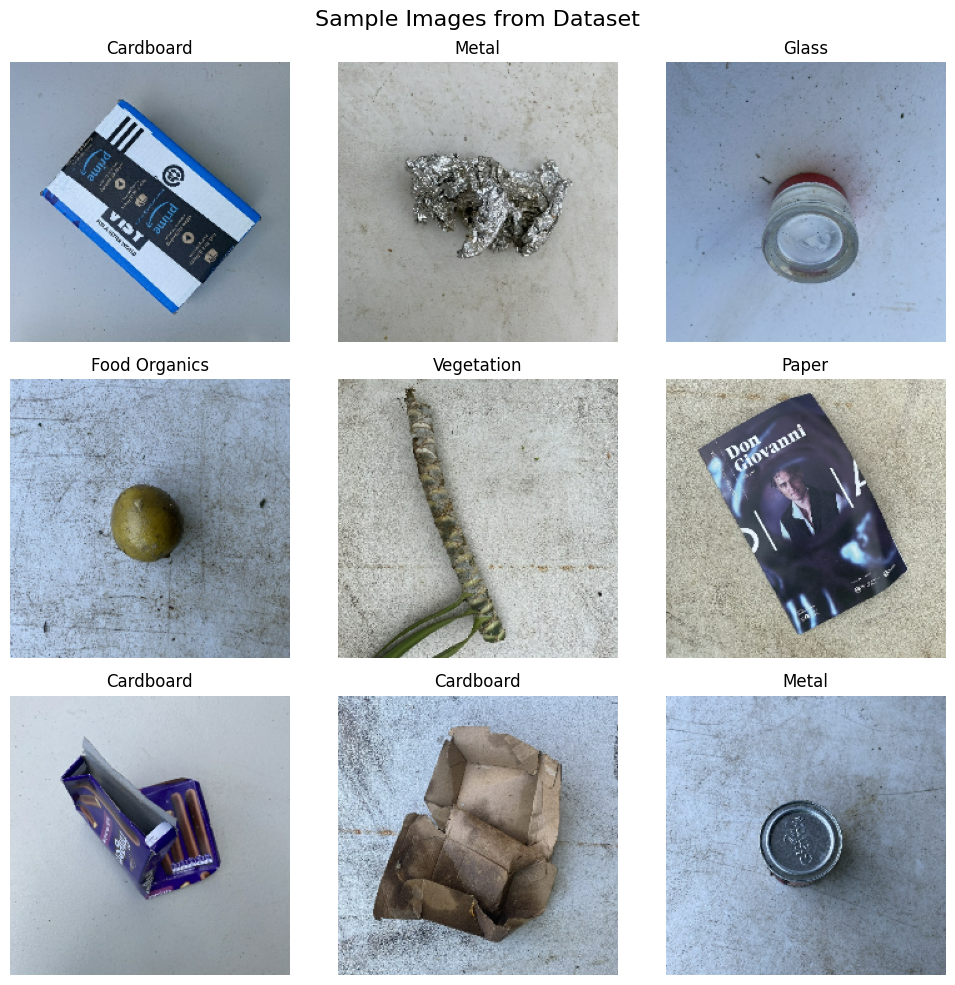

In [ ]:
# visualizing the dataset
plt.figure(figsize=(10, 10))


for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]
    label_idx = labels[i].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



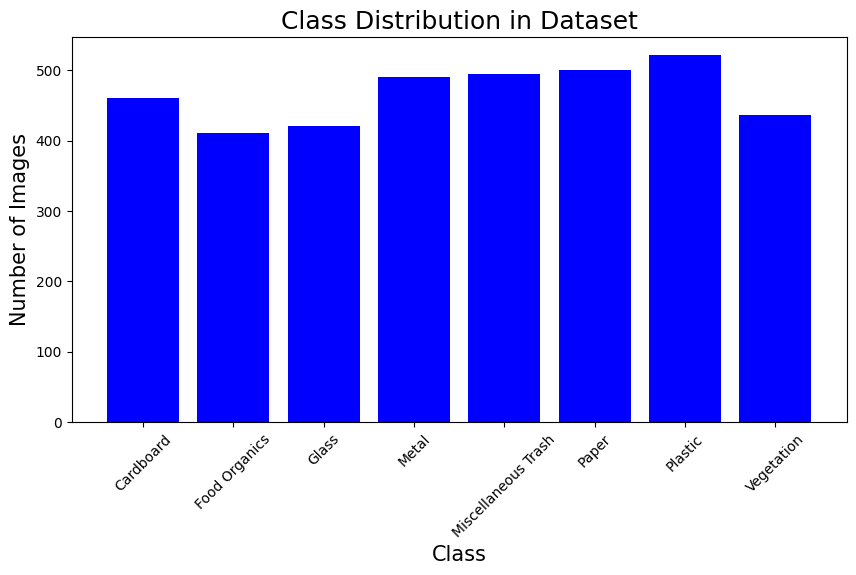

In [ ]:
# visualizing the class distribution
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

# Basline CNN


In [ ]:
# adding exponential decay of learning rate and calling learning rate scheduler
def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)



In [ ]:
# Callback to reduce the learning rate by half
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
input_layer = Input(shape=(224, 224, 3))
# convolutional layer
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(x)

# dense layer
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)

# compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 491,592 (1.88 MB)

 Trainable params: 489,864 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# traing the model
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset,  callbacks=[lr_scheduler, reduce_lr])

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 363s 425ms/step - accuracy: 0.2333 - loss: 2.9252 - val_accuracy: 0.1195 - val_loss: 2.9068 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.3730 - loss: 2.3235 - val_accuracy: 0.1562 - val_loss: 3.0461 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.4207 - loss: 2.1396 - val_accuracy: 0.1250 - val_loss: 4.7861 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4305 - loss: 2.0244
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.4307 - loss: 2.0240 - val_accuracy: 0.1268 - val_loss: 4.9453 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 443ms/step - accuracy: 0.4726 - loss: 1.9216 - val_accuracy: 0.1765 - val_loss: 3.2692 - learning_rate: 5.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.5490 - loss:

In [ ]:
# saving the model
model.save("/content/drive/MyDrive/my_model.keras")

In [ ]:
# creating lists to store true labels and predicted probabilities
y_true_base = []
y_pred_probs_base = []

# loop over validation dataset to collect predictions and true labels
for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)
# convert lists to NumPy arrays
y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)

# convert predicted probabilities to predicted class indices
y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [ ]:
# convert one-hot encoded true labels to class indices
if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)

# printing the classification report
print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        66
           1       0.31      0.28      0.29        54
           2       0.77      0.43      0.56        69
           3       0.78      0.71      0.74        75
           4       0.50      0.23      0.32        64
           5       0.40      0.80      0.53        66
           6       0.59      0.43      0.50        82
           7       0.55      0.87      0.67        68

    accuracy                           0.56       544
   macro avg       0.59      0.56      0.54       544
weighted avg       0.60      0.56      0.55       544



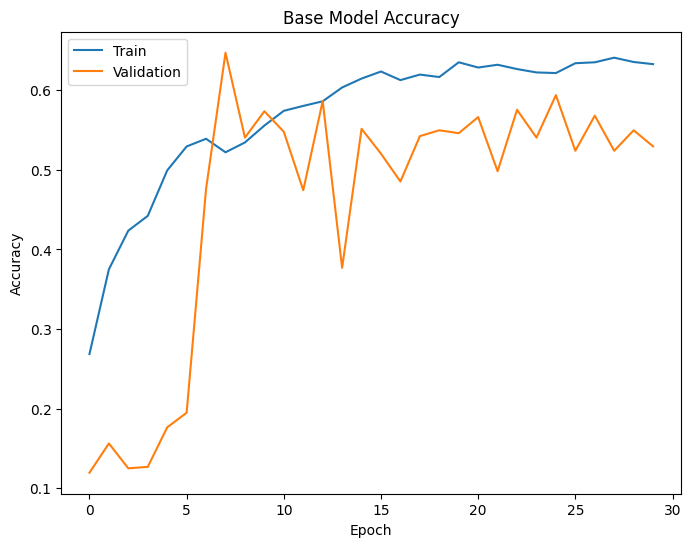

In [ ]:
# plotting the accuracy graph
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

plot_hist(history)

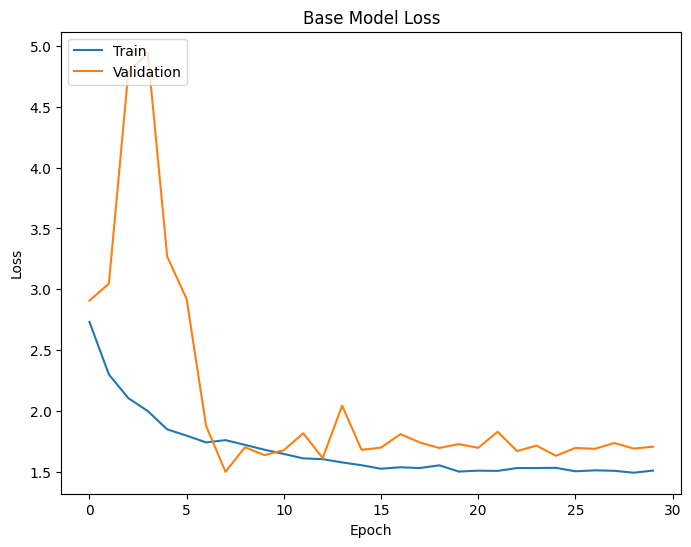

In [ ]:
# plotting the loss graph
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

plot_hist(history)

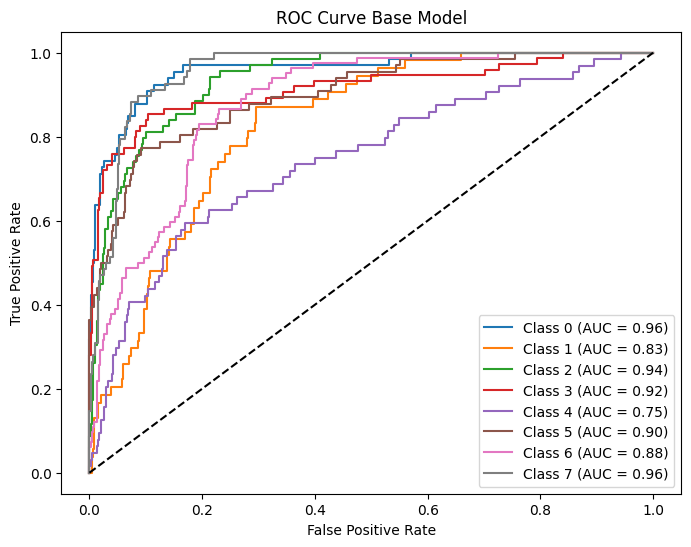

In [ ]:
num_classes = 8
# converting the true class indices to one-hot encoded
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # calculate FPR and TPR
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    # plotting the ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Base Model")
plt.legend()
plt.show()

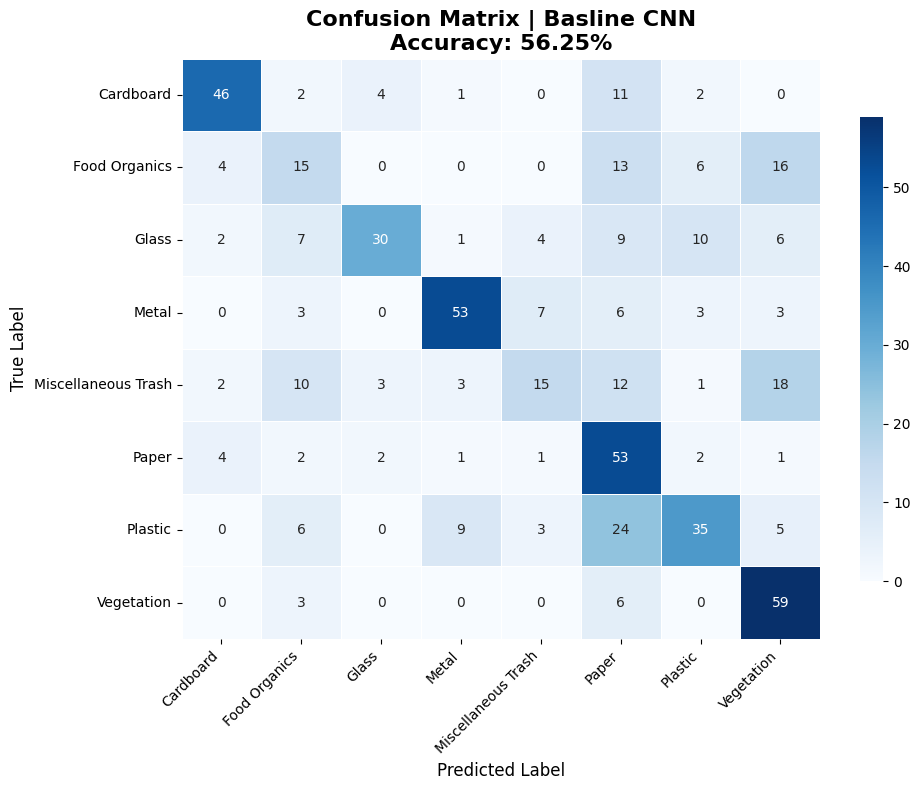

In [ ]:
# function to plot confusion matrix with heatmap and accuracy display
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Basline CNN"):
    # Compute the confusion matrix and accuracy
    cm = confusion_matrix(y_true_base, y_pred_base)
    acc = accuracy_score(y_true_base, y_pred_base) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
# displaying the plot
plot_confusion_matrix(y_true_base, y_pred_base, class_names, model_name="Basline CNN")

In [ ]:
# getting the test accuracy
test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5777 - loss: 1.6522
Test Accuracy: 0.5635
Test Loss: 1.6819


In [ ]:
# loading the saved model
model_base = load_model("/content/drive/MyDrive/my_model.keras")

In [ ]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
         # get the predictions
        predictions = model_base.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            # convert one-hot to label index
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            # get predicted class index
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)

            # convert image to uint8 if normalized
            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")

            # set title color to be green if correct, red if incorrect
            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )

            # display top-3 predicted classes with probabilities
            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


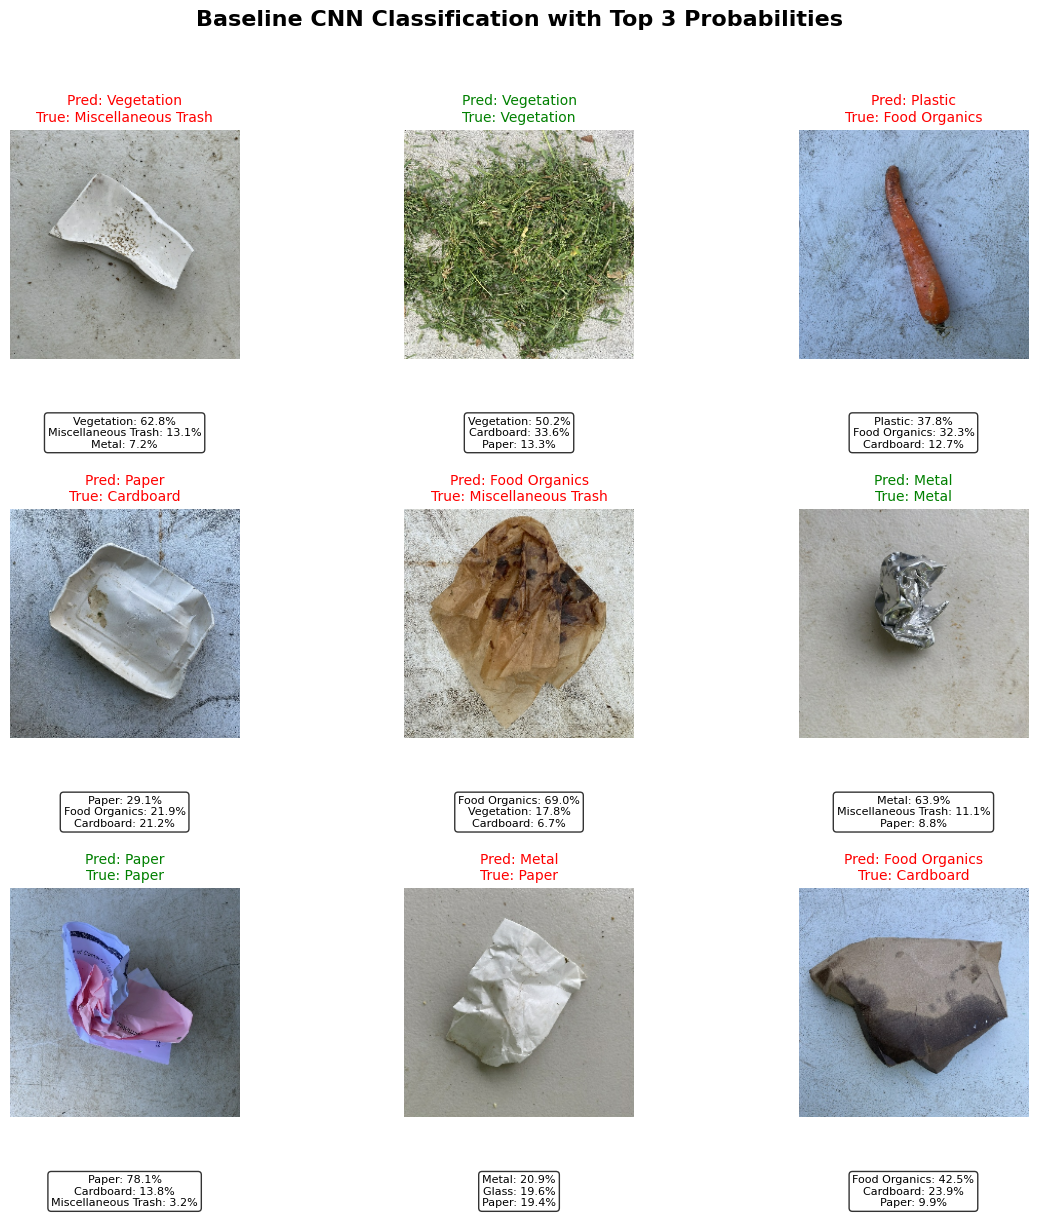

In [ ]:
# plotting the predictions
classify_from_dataset(model_base, test_dataset, class_names)

# Hyperparameter Tuned CNN

In [ ]:
# building the hyperparameter tuned model
def build_model(hp):
    inputs = Input(shape=(224, 224, 3))
    # setting the regulization choice
    l2_value = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    # selecting parameter choice for the convolution layers
    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)

    # setting the parameter choice for the dense layer
    x = layers.Dense(
        hp.Int("units", min_value=64, max_value=512, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout1', min_value=0.4, max_value=0.8, step=0.1))(x)


    # output layer
    outputs = layers.Dense(8, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)

    # compiling the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
        ),
        loss= CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [ ]:
 rm -rf my_tuning/cnn_baseline


In [ ]:
# adding early stopping if val loss is not improving
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# initializing random search for finding the perfect hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stop])


Trial 5 Complete [00h 13m 51s]
val_accuracy: 0.43566176295280457

Best val_accuracy So Far: 0.5330882370471954
Total elapsed time: 01h 04m 53s


In [ ]:
# getting the optimal features
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [ ]:
tuner.results_summary()


Results summary
Results in my_tuning/cnn_baseline
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
l2_reg: 0.006693994895295038
filters_1: 96
filters_2: 64
filters_3: 320
units: 416
dropout1: 0.4
learning_rate: 1e-05
Score: 0.5330882370471954

Trial 0 summary
Hyperparameters:
l2_reg: 0.004028122259221392
filters_1: 32
filters_2: 64
filters_3: 384
units: 320
dropout1: 0.4
learning_rate: 1e-05
Score: 0.4797794073820114

Trial 4 summary
Hyperparameters:
l2_reg: 0.0075192820434624935
filters_1: 32
filters_2: 64
filters_3: 192
units: 416
dropout1: 0.7000000000000001
learning_rate: 0.001
Score: 0.43566176295280457

Trial 1 summary
Hyperparameters:
l2_reg: 0.009456614954514173
filters_1: 32
filters_2: 128
filters_3: 128
units: 256
dropout1: 0.4
learning_rate: 1e-05
Score: 0.40808823704719543

Trial 2 summary
Hyperparameters:
l2_reg: 0.00017700539761307996
filters_1: 32
filters_2: 192
filters_3: 512
units: 64
dropout1: 0.4
learning_rate: 

In [ ]:
# training the model
history_hyper = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler, reduce_lr]
)


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 413ms/step - accuracy: 0.1747 - loss: 6.3365 - val_accuracy: 0.1232 - val_loss: 5.8598 - learning_rate: 1.0000e-05
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.2952 - loss: 5.7768 - val_accuracy: 0.1415 - val_loss: 6.0244 - learning_rate: 1.0000e-05
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.3481 - loss: 5.6312 - val_accuracy: 0.1857 - val_loss: 6.2362 - learning_rate: 1.0000e-05
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.3689 - loss: 5.5450
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 437ms/step - accuracy: 0.3690 - loss: 5.5446 - val_accuracy: 0.1434 - val_loss: 6.3914 - learning_rate: 1.0000e-05
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.3942 - loss: 5.4618 - val_accuracy: 0.1415 - val_loss: 6.4184 - learning_rate: 5.0000e-06
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy:

In [ ]:
# saving the model
best_model.save("/content/drive/MyDrive/my_best_model.keras")

In [ ]:
# creating lists to store true labels and predicted probabilities
y_true_hyper = []
y_pred_probs_hyper = []

# loop over validation dataset to collect predictions and true labels
for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_hyper.extend(labels.numpy())
    y_pred_probs_hyper.extend(preds)

y_pred_probs_hyper = np.array(y_pred_probs_hyper)
y_true_hyper = np.array(y_true_hyper)


y_pred_hyper = np.argmax(y_pred_probs_hyper, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [ ]:
# convert one-hot encoded true labels to class indices
if y_true_hyper.ndim > 1:
    y_true_hyper = np.argmax(y_true_hyper, axis=1)


print(classification_report(y_true_hyper, y_pred_hyper))

              precision    recall  f1-score   support

           0       0.32      0.85      0.47        54
           1       0.56      0.15      0.24        60
           2       0.76      0.57      0.65        67
           3       0.58      0.65      0.61        77
           4       0.56      0.12      0.19        78
           5       0.65      0.48      0.56        66
           6       0.72      0.15      0.25        86
           7       0.34      1.00      0.50        56

    accuracy                           0.47       544
   macro avg       0.56      0.50      0.43       544
weighted avg       0.58      0.47      0.43       544



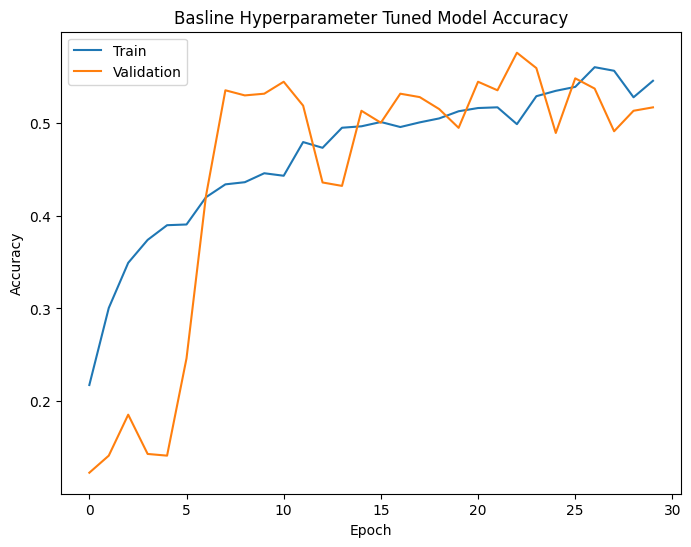

In [ ]:
# plotting the accuracy graph
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["accuracy"])
    plt.plot(history_hyper.history["val_accuracy"])
    plt.title("Basline Hyperparameter Tuned Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

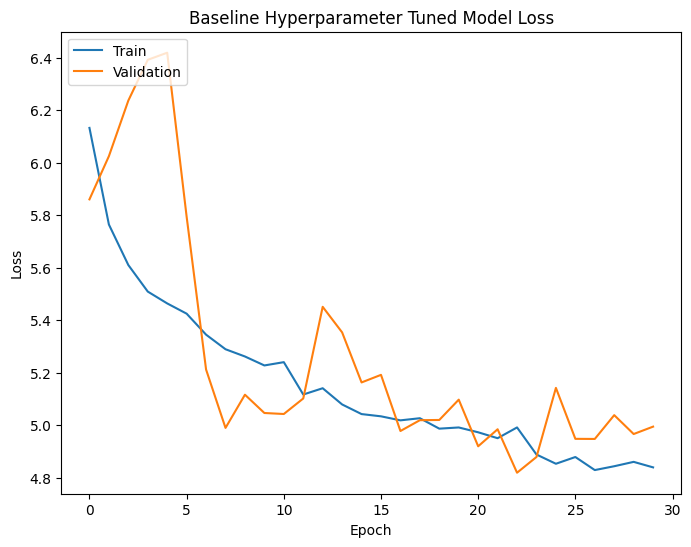

In [ ]:
# plotting the loss graph
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["loss"])
    plt.plot(history_hyper.history["val_loss"])
    plt.title("Baseline Hyperparameter Tuned Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

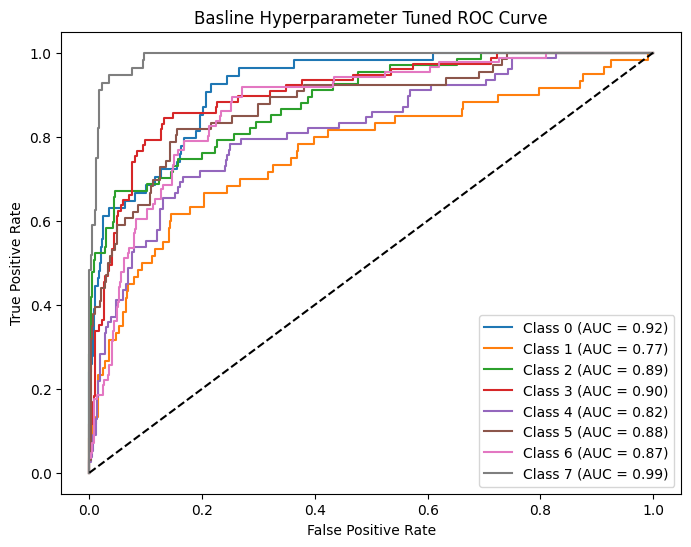

In [ ]:
num_classes = 8
# converting the true class indices to one-hot encoded
y_true_one_hot = to_categorical(y_true_hyper, num_classes)


plt.figure(figsize=(8, 6))

for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_hyper[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Basline Hyperparameter Tuned ROC Curve")
plt.legend()
# plotting the roc curve
plt.show()

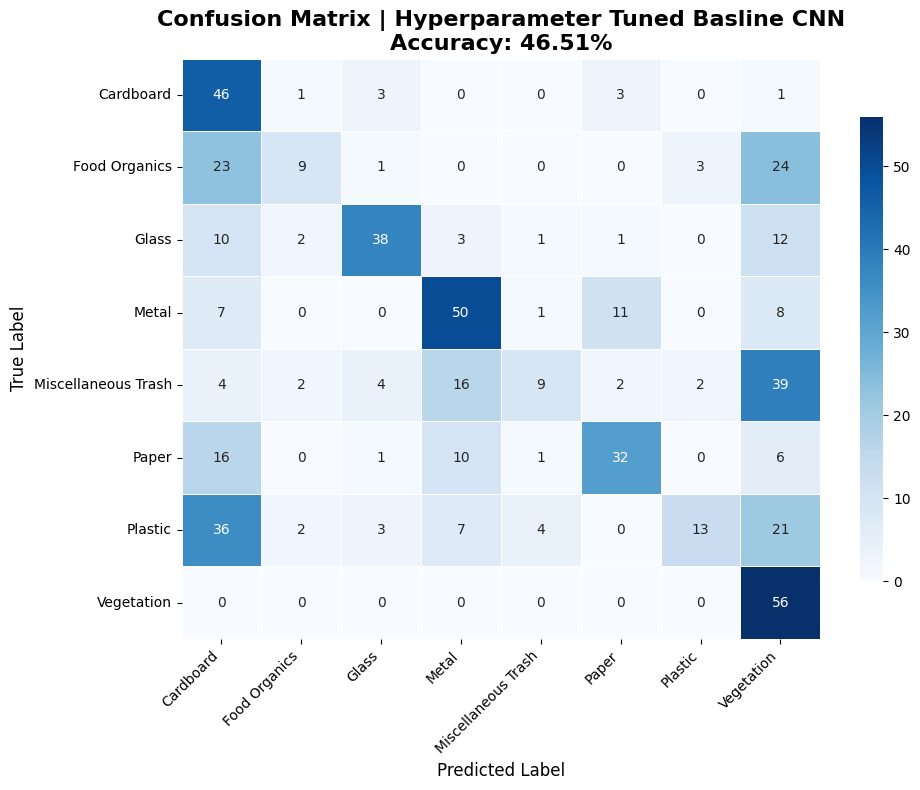

In [ ]:
# function to plot confusion matrix with heatmap and accuracy display
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Hyperparameter Tuned Basline CNN"):
    # Compute the confusion matrix and accuracy
    cm = confusion_matrix(y_true_hyper, y_pred_hyper)
    acc = accuracy_score(y_true_hyper, y_pred_hyper) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
# displaying the plot
plot_confusion_matrix(y_true_hyper, y_pred_hyper, class_names, model_name="Hyperparameter Tuned Basline CNN")

In [ ]:
# getting the test accuracy
test_loss_base, test_acc_base = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5160 - loss: 4.9419
Test Accuracy: 0.5201
Test Loss: 4.9954


In [ ]:
# loading the saved model
model_hyper = load_model("/content/drive/MyDrive/my_best_model.keras")

In [ ]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
         # get the predictions
        predictions = model_hyper.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)

            # convert image to uint8 if normalized
            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")

            # set title color to be green if correct, red if incorrect
            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )

            # display top-3 predicted classes with probabilities
            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline Hyperparametered CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



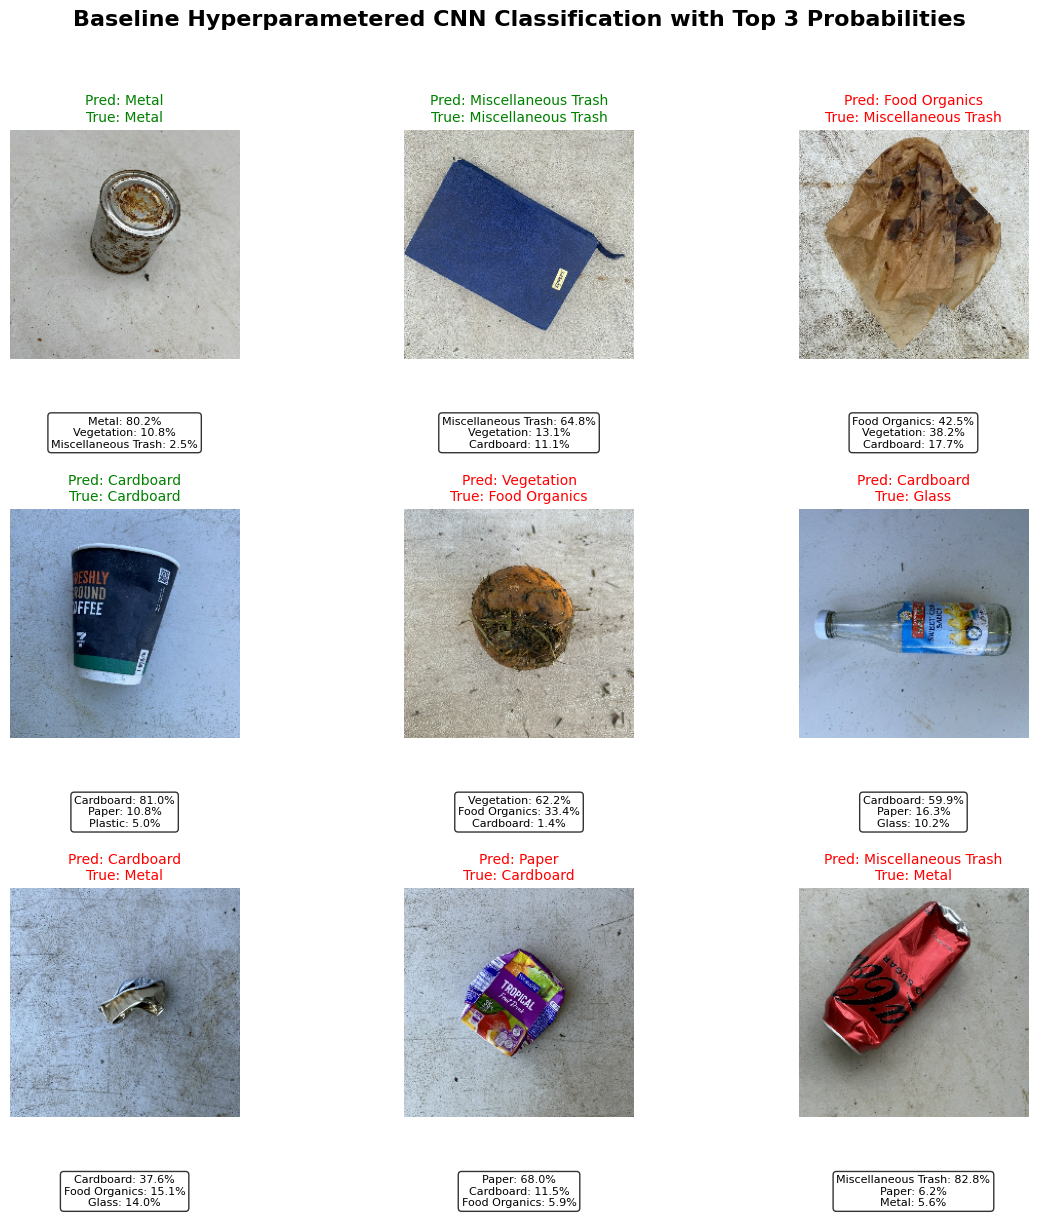

In [ ]:
classify_from_dataset(model_hyper, test_dataset, class_names)

# Hyperparameter Tuned CNN With SVM

In [ ]:
# extracting the features from the model
feature_extractor = Model(inputs=model_hyper.input, outputs=model_hyper.get_layer(index=-3).output)

In [ ]:
feature_extractor.save('/content/drive/MyDrive/feature_extractor.keras')

In [ ]:
def extract_features(dataset, feature_model):
    # lists to store extracted features and labels
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        # pass images through the feature extractor model
        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)
        # store the features from the current batch
        features.append(batch_features)

        # convert one-hot encoded labels to class indices if necessary
        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)

In [ ]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):
    # append the single image and label from the batch to the lists
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])
# stack all images and labels into single TensorFlow tensors
all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [ ]:
# extract deep features and labels
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

In [ ]:
image_array = all_images.numpy()
label_array = all_labels.numpy()

# applying StratifiedShuffleSplit to ensure class distribution is maintained
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split using extracted features X and their corresponding labels y
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test = label_array[test_index]



In [ ]:
np.save('/content/drive/MyDrive/X_test_images_hyper.npy', X_test_images)
np.save('/content/drive/MyDrive/y_test_hyper.npy', y_test)


In [ ]:
# use StandardScaler to normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# make dictionary for the parameter
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],

}
# stratified K-Fold cross-validation to maintain class distribution
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# svm classifier
svm = SVC(random_state=42, probability=True)

# searching the best parameter
grid_search = GridSearchCV(svm, param_grid, cv=stratified_cv, verbose=1, n_jobs=-1)
# fitting the model
grid_search.fit(X_train_scaled, y_train)

# printing the output
print("Best Parameters:", grid_search.best_params_)
print("Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.7920959311608209


In [ ]:
# getting the best model
svm_model = grid_search.best_estimator_


In [ ]:
# getting the test accuracy and the classification report
y_pred = svm_model.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.7965194109772423
Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.72      0.77      0.75        92
      Food Organics       0.84      0.82      0.83        82
              Glass       0.82      0.86      0.84        84
              Metal       0.76      0.82      0.79        98
Miscellaneous Trash       0.72      0.69      0.70        99
              Paper       0.84      0.78      0.81       100
            Plastic       0.80      0.78      0.79       105
         Vegetation       0.91      0.89      0.90        87

           accuracy                           0.80       747
          macro avg       0.80      0.80      0.80       747
       weighted avg       0.80      0.80      0.80       747



In [ ]:
# printing the predicted vs the true labels
y_pred_batch = svm_model.predict(X_test_scaled[:20])
print("Predicted labels:", y_pred_batch)
print("True labels:", y_test[:20])


Predicted labels: [2 6 6 0 6 5 0 5 5 7 1 4 0 0 0 3 3 4 4 4]
True labels: [2 6 6 1 6 4 0 5 5 7 4 4 0 5 0 3 3 4 4 4]


In [ ]:
print("Feature shape:", X.shape)
print("Feature variance:", np.var(X, axis=0).mean())


Feature shape: (3734, 416)
Feature variance: 92931.09


In [ ]:
joblib.dump({'model': svm_model, 'scaler': scaler}, '/content/drive/MyDrive/svm_bundle_hyper.pkl')

['/content/drive/MyDrive/svm_bundle_hyper.pkl']

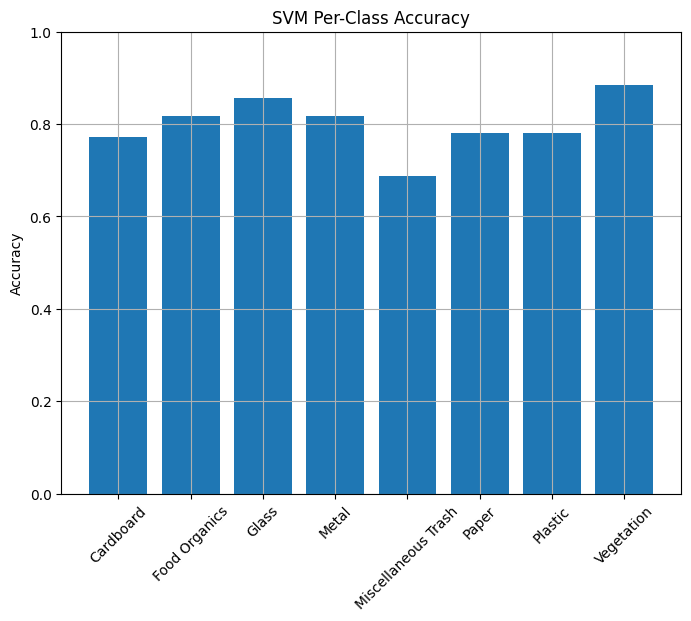

In [ ]:
# plotting the accuracy per class
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test == i)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy")
plt.title("SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


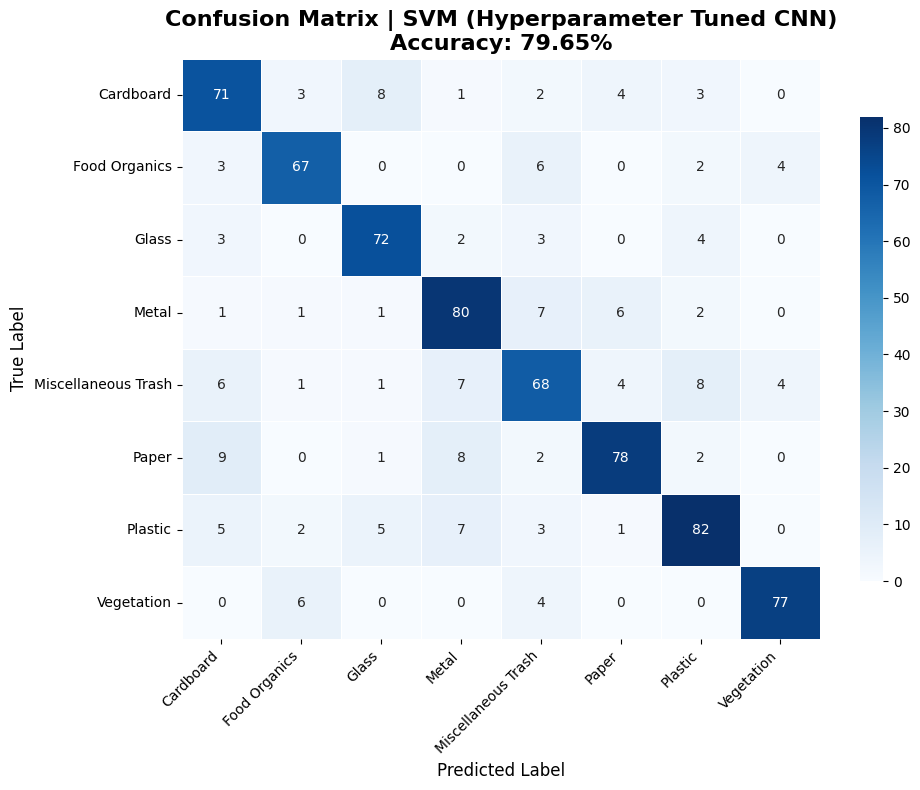

In [ ]:
# function to plot confusion matrix with heatmap and accuracy display
def plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)"):
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)")

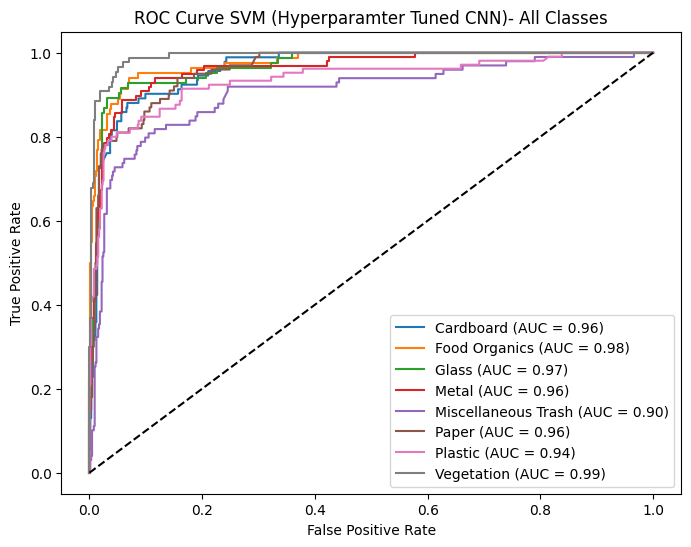

In [ ]:
# Binarize the test labels to compute ROC for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

# returns the distance to the separating hyperplane for each class
probs = grid_search.decision_function(X_test_scaled)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting the roc curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM (Hyperparamter Tuned CNN)- All Classes')
plt.legend()
plt.show()


In [11]:
# Load the SVM model and scaler
bundle = joblib.load('/content/drive/MyDrive/svm_bundle_hyper.pkl')
svm_model = bundle['model']
scaler = bundle['scaler']
feature_extractor = load_model('/content/drive/MyDrive/feature_extractor.keras')
X_test_images = np.load('/content/drive/MyDrive/X_test_images_hyper.npy')
y_test = np.load('/content/drive/MyDrive/y_test_hyper.npy')

In [12]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):
    # convert input tensors to NumPy arrays for processing
    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test.numpy() if tf.is_tensor(y_test) else np.array(y_test)
    # getting random image indices for visualization
    num_images = num_rows * num_cols
    total_images = X.shape[0]

    indices = random.sample(range(total_images), num_images)
    images = X[indices]
    true_labels = y[indices]

    features = feature_extractor.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))
    features_scaled = scaler.transform(features)

    # get predictions and predicted probabilities from the trained SVM
    pred_labels = svm_model.predict(features_scaled)
    probs = svm_model.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')
        # plotting green if correct, red if incorrect
        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)

        # show top 3 predicted probabilities
        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle("SVM on Hyperparameter Tuned CNN Features: Classification with Top 3 Probabilities",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


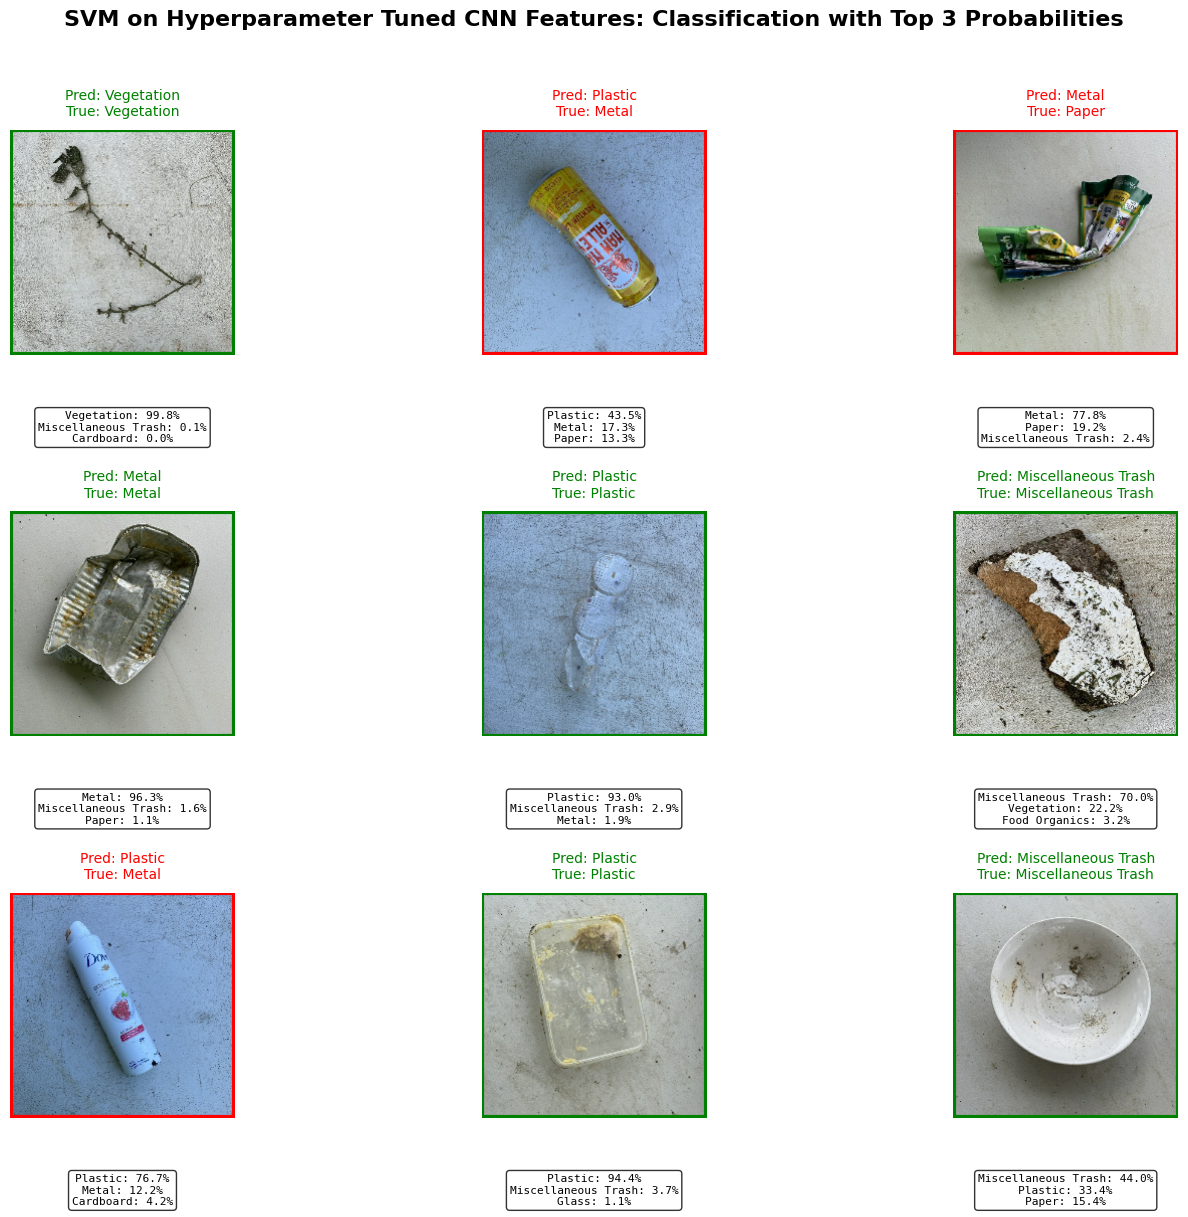

In [13]:
# visualize the predictions
visualize_predictions_with_probs(
    feature_extractor,
    svm_model,
    scaler,
    X_test_images=X_test_images,
    y_test=y_test,
    class_names=class_names
)


# Basline CNN With SVM

In [ ]:
# extract features from the base model
feature_extractor_basline = Model(inputs=model_base.input, outputs=model_base.layers[-3].output)

In [ ]:
feature_extractor_basline.save('/content/drive/MyDrive/feature_extractor_base.keras')

In [ ]:
def extract_features(dataset, feature_model):
    # lists to store extracted features and labels
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        # pass images through the feature extractor model
        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)
        # store the features from the current batch
        features.append(batch_features)

        # convert one-hot encoded labels to class indices if necessary
        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)


In [ ]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])
# stack all images and labels into single TensorFlow tensors
all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [ ]:
# extract deep features and labels
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor_basline)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

In [ ]:
image_array = all_images.numpy()
label_array = all_labels.numpy()

# applying StratifiedShuffleSplit to ensure class distribution is maintained
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split using extracted features X and their corresponding labels y
for train_index, test_index in sss.split(X, y):
    X_train_basline, X_test_basline = X[train_index], X[test_index]
    y_train_basline, y_test_basline = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test_basline = label_array[test_index]



In [ ]:
np.save('/content/drive/MyDrive/X_test_images_baseline.npy', X_test_images)
np.save('/content/drive/MyDrive/y_test_baseline.npy', y_test_basline)


In [ ]:
# use StandardScaler to normalize the features
scaler_basline = StandardScaler()
X_train_scaled_basline = scaler_basline.fit_transform(X_train_basline)
X_test_scaled_basline = scaler_basline.transform(X_test_basline)

In [ ]:
# dictionary to store parameter
param_grid_basline = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],
}
# stratified K-Fold cross-validation to maintain class distribution
stratified_cv_basline = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# # svm classifier
svm_basline = SVC(random_state=42, probability=True)

# search for the best parameter
grid_search_basline = GridSearchCV(svm_basline, param_grid_basline, cv=stratified_cv_basline, verbose=1, n_jobs=-1)
# fit the model
grid_search_basline.fit(X_train_scaled_basline, y_train_basline)

# print the accuracy and the best parameter
print("Best Parameters Basline:", grid_search_basline.best_params_)
print("Cross-Validation Accuracy Basline:", grid_search_basline.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters Basline: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Cross-Validation Accuracy Basline: 0.7074071584231076


In [ ]:
# getting the best model
svm_model_basline = grid_search_basline.best_estimator_

In [ ]:
# getting the prediction
y_pred_basline = svm_model_basline.predict(X_test_scaled_basline)

# printing the accuracy and the classification report
print("Test Accuracy Basline:", accuracy_score(y_test_basline, y_pred_basline))
print("Classification Report Basline:\n", classification_report(y_test_basline, y_pred_basline, target_names=class_names))


Test Accuracy Basline: 0.7349397590361446
Classification Report Basline:
                      precision    recall  f1-score   support

          Cardboard       0.76      0.78      0.77        92
      Food Organics       0.78      0.82      0.80        82
              Glass       0.77      0.77      0.77        84
              Metal       0.69      0.71      0.70        98
Miscellaneous Trash       0.61      0.58      0.59        99
              Paper       0.81      0.64      0.72       100
            Plastic       0.63      0.73      0.68       105
         Vegetation       0.89      0.89      0.89        87

           accuracy                           0.73       747
          macro avg       0.74      0.74      0.74       747
       weighted avg       0.74      0.73      0.73       747



In [ ]:
# save both the trained SVM model and the scaler used for feature normalization
joblib.dump({'model_b': svm_model_basline, 'scaler_b': scaler_basline}, '/content/drive/MyDrive/svm_bundle.pkl')

['/content/drive/MyDrive/svm_bundle.pkl']

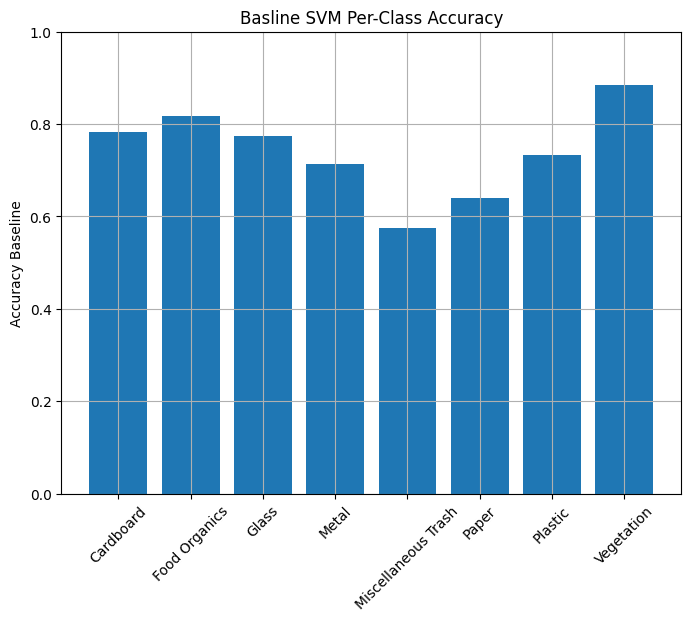

In [ ]:
# plot the accuracy per class
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test_basline == i)
    acc = accuracy_score(y_test_basline[idx], y_pred_basline[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy Baseline")
plt.title("Basline SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


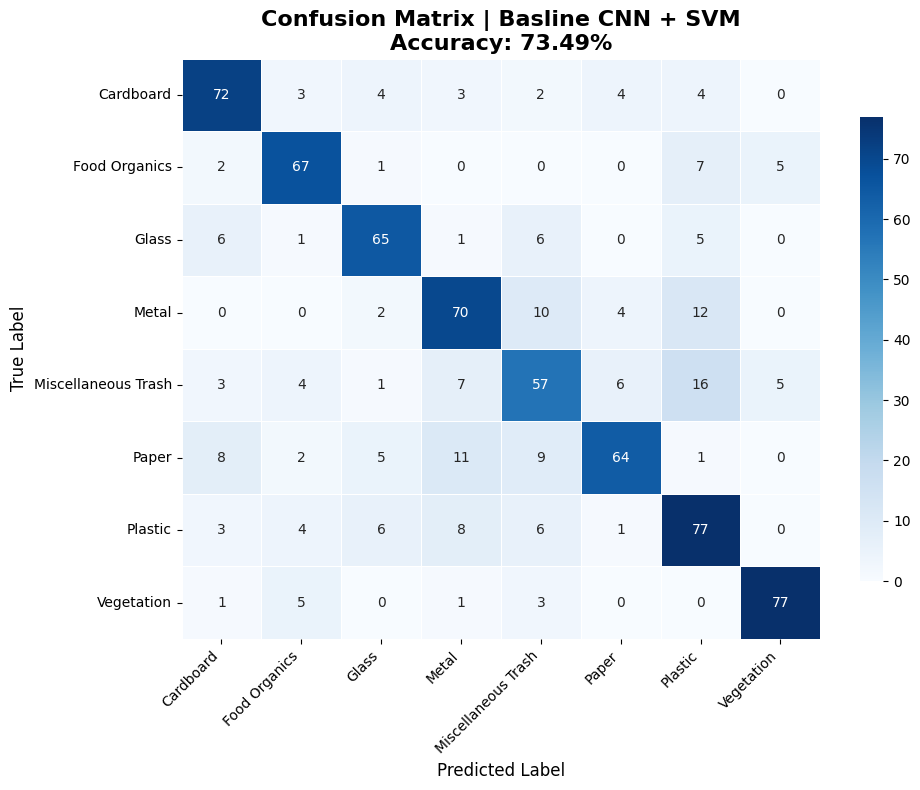

In [ ]:
# funtion to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Basline CNN + SVM"):
    # getting the accuracy for the matrix
    cm = confusion_matrix(y_test_basline, y_pred_basline)
    acc = accuracy_score(y_test_basline, y_pred_basline) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})
    # plotting the matrix
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test_basline, y_pred_basline, class_names, model_name="Basline CNN + SVM")

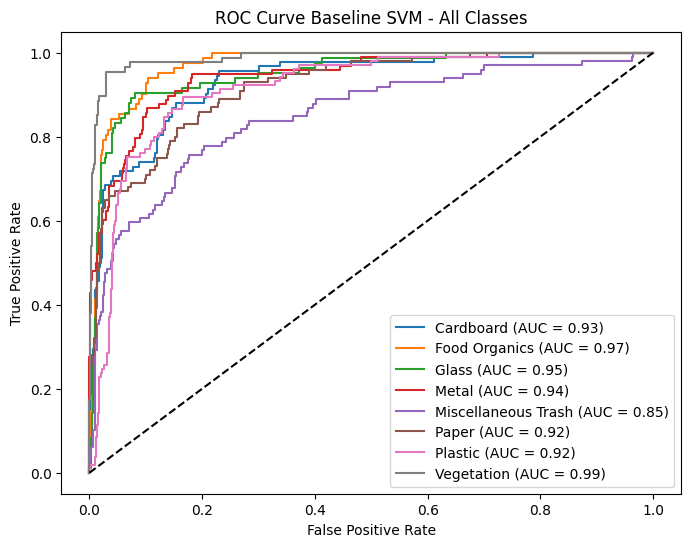

In [ ]:
# Binarize the test labels to compute ROC for each class
y_test_bin = label_binarize(y_test_basline , classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

# returns the distance to the separating hyperplane for each class
probs = grid_search_basline.decision_function(X_test_scaled_basline)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting the curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Baseline SVM - All Classes')
plt.legend()
plt.show()


In [14]:
# Load the SVM model and scaler
bundle = joblib.load('/content/drive/MyDrive/svm_bundle.pkl')
svm_model_basline = bundle['model_b']
scaler_basline = bundle['scaler_b']
feature_extractor_basline = load_model('/content/drive/MyDrive/feature_extractor_base.keras')
X_test_images = np.load('/content/drive/MyDrive/X_test_images_baseline.npy')
y_test_basline = np.load('/content/drive/MyDrive/y_test_baseline.npy')

In [15]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):
    # Convert input tensors to NumPy arrays for processing
    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test_basline.numpy() if tf.is_tensor(y_test_basline) else np.array(y_test_basline)

    # getting random image indices for visualization
    num_images = num_rows * num_cols
    idxs = np.random.choice(len(X), size=num_images, replace=False)
    images = X[idxs]
    true_labels = y[idxs]



    features = feature_extractor_basline.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))


    features_scaled = scaler_basline.transform(features)

    # get predictions and predicted probabilities from the trained SVM
    pred_labels = svm_model_basline.predict(features_scaled)
    probs = svm_model_basline.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')
        # plotting green if correct, red if incorrect
        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)

        # show top 3 predicted probabilities
        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))


        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle(" SVM on Basline CNN Features: Classification with Top 3 Probabilities ",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



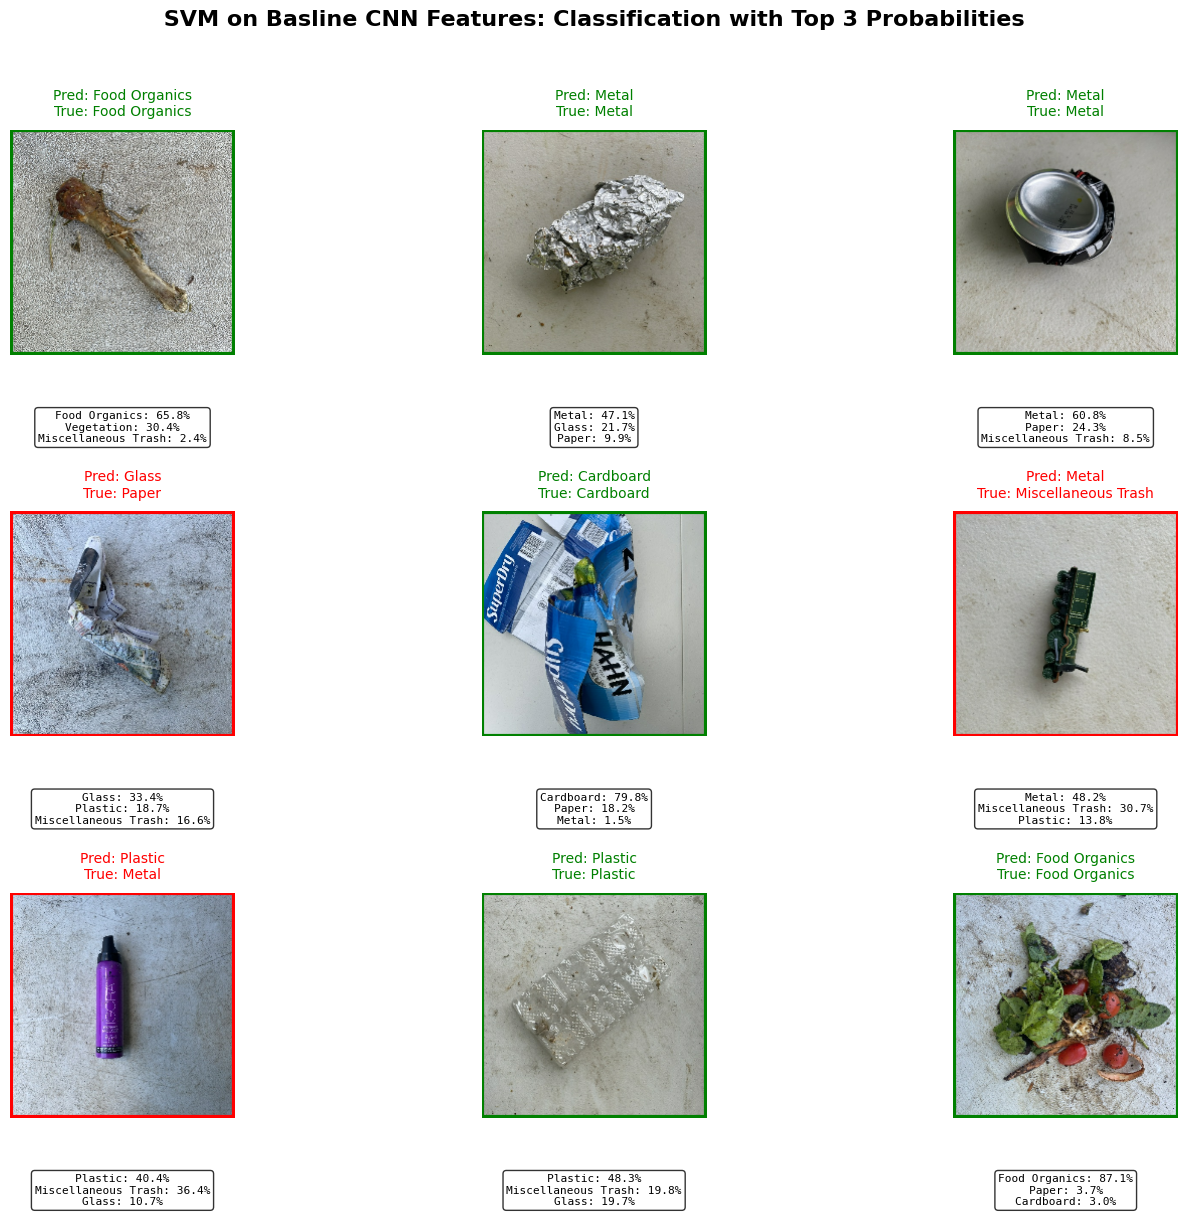

In [16]:
# plotting the predictions
visualize_predictions_with_probs(
    feature_extractor_basline,
    svm_model_basline,
    scaler_basline,
    X_test_images=X_test_images,
    y_test=y_test_basline,
    class_names=class_names
)
